# 01-04: Regressione con OLS

**4.1 Si usino i dati dell'Es 2 per prevedere la variabile age, usando tutte le altre tranne group. È richiesto di considerare nonlinearità e interazioni, di fare la selezione delle variabili e di studiare i residui graficamente.**

## EDA e PCA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
base = pd.read_excel("inml25tst01.xlsx", sheet_name="Es 2")

df = base.drop(columns=base.columns[0:9])

df = df.set_index("id")
df = df.sort_index()          # ordina per id

df_test  = df.tail(200)
df_train = df.iloc[:-200]

# ALTERNATIVA
# df_train = df[df["age"].isna() != True]
# df_test = df[df["age"].isna()]

In [3]:
X_train = df_train.drop(columns=["age", "group"])
y_train = df_train["age"].values

print(df_train.shape)
print(X_train.columns)

X_train = X_train.values

print(X_train.shape)
print(y_train.shape)

(2078, 9)
Index(['gender', 'PA', 'BMI', 'GLU', 'diabetic', 'GLT', 'insulin'], dtype='object')
(2078, 7)
(2078,)


In [4]:
X_test = df_test.drop(columns=["age", "group"])

print(df_test.shape)
print(X_test.columns)

X_test = X_test.values

print(X_test.shape)

(200, 9)
Index(['gender', 'PA', 'BMI', 'GLU', 'diabetic', 'GLT', 'insulin'], dtype='object')
(200, 7)


In [5]:
mean = np.mean(X_train, axis=0)

X_train = X_train - mean
X_test = X_test - mean

pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0, ddof=1)

X_train = ( X_train - mean) / std
X_test = ( X_test - mean) / std

In [6]:
print(np.unique(y_train, return_counts=True))

(array([12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
       25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
       38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.,
       51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63.,
       64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76.,
       77., 78., 79., 80.]), array([55, 43, 56, 45, 64, 42, 65, 39, 29, 31, 27, 30, 28, 34, 35, 32, 25,
       23, 29, 33, 33, 28, 33, 22, 42, 24, 27, 23, 38, 34, 23, 43, 38, 33,
       29, 32, 30, 18, 39, 36, 20, 25, 26, 39, 29, 26, 20, 28, 33, 25, 25,
       44, 24, 22, 26, 14, 18, 14, 20, 21, 16, 20, 12, 12, 11,  9,  8,  8,
       93]))


## Introduzione di termini non lineari

In [7]:
X_train_nl = np.column_stack(
    [
        X_train,  
        X_train[:,0]**2,
        X_train[:,0]**3,
        X_train[:,0]**4, 
        X_train[:,1]**2,
    ]
)

print(X_train_nl.shape)

(2078, 6)


Ristardandizziamo

In [8]:
mean = np.mean(X_train_nl, axis=0)
std = np.std(X_train_nl, axis=0, ddof=1)

X_train_nl = ( X_train_nl - mean) / std

**4.2 Si forniscano le previsioni di age per gli ultimi 200 id. Per ciascuno, si dia anche l'intervallo di predizione al 95%.**

In [9]:
import statsmodels.api as sm

Aggiungiamo l'intercetta

In [10]:
X_train_nl = sm.add_constant(X_train_nl)
print(X_train_nl.shape)

(2078, 7)


## Analisi delle feature più rilevanti con OLS

In [11]:
model = sm.OLS(y_train, X_train_nl).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     64.79
Date:                Thu, 05 Feb 2026   Prob (F-statistic):           5.86e-74
Time:                        16:09:15   Log-Likelihood:                -9008.4
No. Observations:                2078   AIC:                         1.803e+04
Df Residuals:                    2071   BIC:                         1.807e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.5833      0.406    102.453      0.0

Questo summary riassume i risultati della regressione OLS, cioè come ciascuna variabile esplicativa contribuisce a spiegare la variabile risposta `age`, a parità delle altre.

La colonna **coef** contiene le stime dei coefficienti del modello. Ogni valore indica di quanto varia `age` in media per un aumento unitario della corrispondente variabile, mantenendo fisse le altre.

Il termine **const** è l’intercetta e rappresenta il valore medio atteso di `age` quando tutte le covariate valgono zero (qui zero è da intendersi nello spazio trasformato e standardizzato).

La colonna **std err** riporta l’errore standard associato a ciascun coefficiente. Misura l’incertezza della stima. A parità di coefficiente, errori standard più piccoli indicano stime più precise.

La colonna **t** è la statistica t di Student, calcolata come rapporto tra il coefficiente stimato e il suo errore standard. Serve per testare l’ipotesi nulla che il coefficiente sia uguale a zero.

La colonna **P>|t|** è il p-value del test t. Valori piccoli (tipicamente < 0.05) indicano che la variabile è statisticamente significativa, cioè contribuisce in modo rilevante alla spiegazione di `age` una volta tenute fisse le altre covariate. Valori grandi suggeriscono invece che il termine può essere rimosso dal modello.

Le colonne **[0.025, 0.975]** rappresentano l’intervallo di confidenza al 95% per ciascun coefficiente. Se l’intervallo include lo zero, la variabile non è significativa a quel livello; se non lo include, l’effetto è compatibile con un contributo diverso da zero.

**In questo modello, tutti i termini tranne `x2, x3, x6` risultano significativi. Il termine `x3 e x6` hanno un p-value più elevato e un intervallo di confidenza che include lo zero, quindi non forniscono un contributo informativo aggiuntivo e possono essere eliminati per ottenere un modello più parsimonioso.**

## Regressione con OLS

In [12]:
X_train_nl = np.column_stack(
    [
        X_train,  
        X_train[:,0]**3, 
        X_train[:,0]**4, 
    ]
)

X_test_nl = np.column_stack(
    [
        X_test,  
        X_test[:,0]**3, 
        X_test[:,0]**4, 
    ]
)

print(X_train_nl.shape)
print(X_test_nl.shape)

(2078, 4)
(200, 4)


In [13]:
mean = np.mean(X_train_nl, axis=0)
std = np.std(X_train_nl, axis=0, ddof=1)

X_train_nl = ( X_train_nl - mean) / std
X_test_nl = ( X_test_nl - mean) / std

In [14]:
X_train_nl = sm.add_constant(X_train_nl)
X_test_nl = sm.add_constant(X_test_nl)
print(X_train_nl.shape)
print(X_test_nl.shape)

(2078, 5)
(200, 5)


In [15]:
model = sm.OLS(y_train, X_train_nl).fit()

La **stima puntuale della risposta** è data dai valori predetti
$\hat y_i = x_i^\top \hat\beta,$ 
che in `statsmodels` ottieni come `model.fittedvalues` per i dati di training, oppure tramite `model.predict` per nuovi dati

In [16]:
predictions = model.predict(X_test_nl)
results = pd.DataFrame(predictions, index=df_test.index, columns=["Age"])
results.head(10)

,Age
id,
2079,51.548385
2080,39.304501
2081,31.595369
2082,28.019782
2083,46.204170
2084,47.074833
2085,57.160863
2086,58.383387
2087,41.608662


## Analisi dei Residui


I **residui** sono
$$
e_i = y_i - \hat y_i,
$$
e corrispondono a `model.resid`.

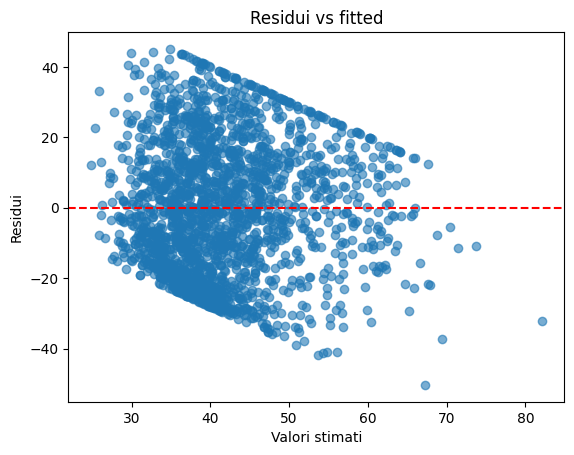

In [17]:
resid  = model.resid
fitted = model.fittedvalues
plt.figure()
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valori stimati")
plt.ylabel("Residui")
plt.title("Residui vs fitted")
plt.show()

Un buon modello mostra una nube casuale centrata attorno a zero. Pattern a U o a ventaglio indicano rispettivamente nonlinearità non catturate o eteroschedasticità.

### Calcolo di $SSR$, $S_e^2$ e $S_e$

La **somma dei quadrati dei residui (SSR)** è
$SSR = \sum_{i=1}^n e_i^2,$ ed è direttamente accessibile come `model.ssr`.

In [18]:
model.ssr

np.float64(709900.7908922035)

La **stima della varianza dell’errore** è
$ S_e^2 = \frac{SSR}{n - p}, $ dove $n$ è il numero di osservazioni e $p$ il numero di parametri stimati (inclusa l’intercetta). In `statsmodels` questo valore è `model.mse_resid`.

In [19]:
model.mse_resid

np.float64(342.4509362721676)

La **deviazione standard dell’errore** è semplicemente
$ S_e = \sqrt{S_e^2}, $ che corrisponde a `np.sqrt(model.mse_resid)`.

In [20]:
np.sqrt(model.mse_resid)

np.float64(18.505429913194874)

### Distribuzione dei residui

Serve a valutare simmetria e presenza di code anomale.

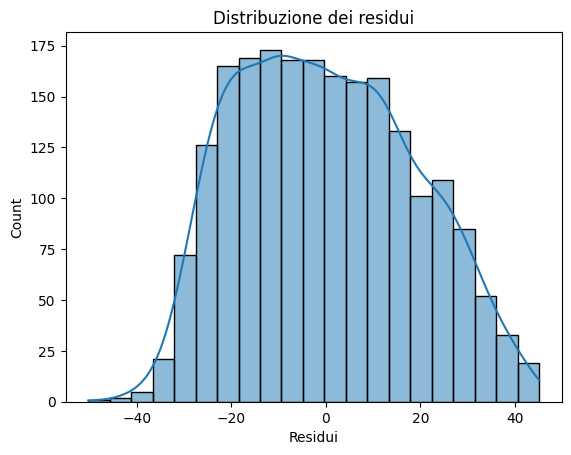

In [21]:
plt.figure()
sns.histplot(resid, kde=True)
plt.xlabel("Residui")
plt.title("Distribuzione dei residui")
plt.show()

### Intervallo di confidenza per la predizione
Per un nuovo punto $x_0$, la **media attesa** della predizione è
$$
\mathbb{E}[Y \mid x_0] = x_0^\top \hat\beta.
$$
L’intervallo di confidenza al livello $1-\alpha$ per la media è
$$
\hat y_0 \;\pm\; t_{n-p,\,1-\alpha/2}
\sqrt{x_0^\top \widehat{\mathrm{Var}}(\hat\beta)\, x_0}.
$$

In pratica, `statsmodels` lo calcola direttamente tramite:

In [22]:
pred = model.get_prediction(X_test_nl[0])
pred.conf_int()

array([[50.22657123, 52.87019812]])

**Nota.** L'intervallo di confidenza è di default al 95%